In [12]:
#Esto sirve para usar los archivos que están en el drive
#(más rápido que subirlos manualmente)
from google.colab import drive
# Montar Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
#Import modules
import numpy as np
import pandas as pd
import random
import cv2

import tensorflow as tf
import albumentations as albu

from tensorflow.keras.models import Sequential
from tensorflow.keras import models, Model, layers, losses, optimizers, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import EfficientNetB3

In [14]:
#Leer archivos
import openpyxl
df = pd.read_excel("/content/drive/MyDrive/Colab/Albers/Arreglos y bases/Base_Albers_Final_81k.xlsx")
y_ref = np.array(df["Coneval_2020"])

print(np.shape(y_ref))
print(np.min(y_ref), np.max(y_ref), np.var(y_ref))

(81428,)
0.0545095096 0.996466762 0.038181904293514514


In [15]:
# Leer imágenes


x_imgs = np.load("/content/drive/MyDrive/Colab/Albers/Arreglos y bases/Arreglos/Geomediana_recortes_Albers_Base_Final.npy")
print(np.shape(x_imgs))

#negativos a 0.0

x_imgs[x_imgs<0.0] = 0.0
#x_imgs[x_imgs==-9999] = 0.0

#scale intensity values
scale = 1.0 / 10000.0
x_imgs = scale * x_imgs

print(np.shape(y_ref))
print(np.min(y_ref), np.max(y_ref), np.var(y_ref))

(81428, 6, 40, 40)
(81428,)
0.0545095096 0.996466762 0.038181904293514514


In [16]:
# Swap de canales para luz de día
x_imgs = np.swapaxes(x_imgs, 1, 3)
x_imgs = np.swapaxes(x_imgs, 1, 2)

print(np.shape(x_imgs))
print(np.min(x_imgs), np.max(x_imgs), np.mean(x_imgs))

(81428, 40, 40, 6)
0.0 2.0 0.17454282926071746


In [17]:
# Crear particiones
random.seed(123)
nrec = len(y_ref)
ntrain = int(0.5 * nrec)
nval = int(0.2 * nrec)

# Índices de partición
ind = np.arange(0, nrec)
random.shuffle(ind)
ind_train = ind[0:ntrain]
ind_val = ind[ntrain:ntrain + nval]
ind_test = ind[ntrain + nval:nrec]

# Partición de imágenes
x_train = x_imgs[ind_train]
x_val = x_imgs[ind_val]
x_test = x_imgs[ind_test]

# Partición de datos
y_train = y_ref[ind_train]
y_val = y_ref[ind_val]
y_test = y_ref[ind_test]

#repeat training data
#repeats = 5 #Seguir probando
#x_train = np.repeat(x_train, repeats, axis=0)
#y_train = np.repeat(y_train, repeats, axis=0)



print(np.shape(x_train), np.shape(x_val), np.shape(x_test))
print(np.shape(y_train), np.shape(y_val), np.shape(y_test))

(40714, 40, 40, 6) (16285, 40, 40, 6) (24429, 40, 40, 6)
(40714,) (16285,) (24429,)


In [18]:
###EfficientNetB3

height, width, channels = 224, 224, 6

cnn_source = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(height, width, 3))

conv_base= EfficientNetB3(weights=None, include_top=False, input_shape=(height, width, 6))

penalty = 0.1
regularizer = tf.keras.regularizers.l2(penalty)

for i in np.arange(6,len(conv_base.layers)):
  layer_source = cnn_source.get_layer(index=i)
  layer_dest = conv_base.get_layer(index=i-1)
  w = layer_source.get_weights()
  layer_dest.set_weights(w)
  for attr in ['kernel_regularizer']:
    if hasattr(layer_dest, attr):
      setattr(layer_dest, attr, regularizer)


/usr/local/lib/python3.11/dist-packages/keras/src/applications/efficientnet.py:289: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 6 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


In [19]:
# Construir el modelo final
model = Sequential()
model.add( conv_base )
model.add( GlobalAveragePooling2D() )
model.add( Dropout(0.5) )
model.add( Dense(1, activation='sigmoid') )

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,784,621 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,786,158 (41.15 MB)

 Trainable params: 10,698,849 (40.81 MB)

 Non-trainable params: 87,309 (341.05 KB)

In [20]:
batch_size = 32

def resize_img(img, shape):
    return cv2.resize(img, (int(shape[1]), int(shape[0])), interpolation=cv2.INTER_CUBIC)

#==============================================================
#data generator for training and validation

In [21]:
np.random.seed(123)
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size=batch_size, dim=(height, width), channels=channels, augment=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.indexes = np.arange(0, len(self.x))
        self.augment = augment

    def __on_epoch_end(self):
        self.indexes = np.arange(0, len(self.x))
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx+1) * self.batch_size]

        #generate mini-batch of X
        scale_dim = 1.6
        X = []
        for i, ID in enumerate(batch_indexes):
            img = self.x[ID]
            img = resize_img(img, (scale_dim*self.dim[0], scale_dim*self.dim[1]))
            X.append(img)
        X = np.array(X)

        #generate mini-batch of y
        y = self.y[batch_indexes]

        #augmentation on the training dataset
        if self.augment==True:
            X = self.__augment_batch(X)

        #crop images to the size of 224 x 224 pixels
        sz = np.shape(X)
        h_off = int(0.5 * (sz[1] - self.dim[0]))
        w_off = int(0.5 * (sz[2] - self.dim[1]))
        X = X[:, h_off:h_off+self.dim[0], w_off:w_off+self.dim[1], :]
        return X, y

    #augmentation for one image
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p=0.5),
                                    albu.VerticalFlip(p=0.5),
                                    albu.GridDistortion(p=0.2),
                                    albu.ElasticTransform(p=0.2),
                                    albu.Rotate(p=1)])
        return composition(image=img)['image']

    #augmentation for batch of images
    def __augment_batch(self, img_batch):
        for i in np.arange(0, len(img_batch)):
            img_batch[i] = self.__random_transform(img_batch[i])
        return img_batch

train_gen = DataGenerator(x_train, y_train, augment=True)
val_gen = DataGenerator(x_val, y_val, augment=False)
test_gen = DataGenerator(x_test, y_test, augment = False) #Agregado 7 marzo de 2025

In [22]:
# Compilar el modelo
learning_rate = 1.0e-4
mse = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, restore_best_weights=True) #
rlrop = ReduceLROnPlateau(monitor="val_loss", mode="min", patience=3, factor=0.5, min_lr=1e-6, verbose=1)

model.compile(optimizer=opt, loss=mse)
# Entrenar el modelo
epochs = 30
res = model.fit(train_gen, validation_data=val_gen, callbacks=[early_stop, rlrop], epochs=epochs, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1359s 983ms/step - loss: 0.0312 - val_loss: 0.0562 - learning_rate: 1.0000e-04
Epoch 2/30
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1194s 938ms/step - loss: 0.0202 - val_loss: 0.0231 - learning_rate: 1.0000e-04
Epoch 3/30
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1198s 941ms/step - loss: 0.0184 - val_loss: 0.0197 - learning_rate: 1.0000e-04
Epoch 4/30
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1224s 962ms/step - loss: 0.0171 - val_loss: 0.0194 - learning_rate: 1.0000e-04
Epoch 5/30
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1205s 946ms/step - loss: 0.0165 - val_loss: 0.0216 - learning_rate: 1.0000e-04
Epoch 6/30
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1204s 945ms/step - loss: 0.0152 - val_loss: 0.0366 - learning_rate: 1.0000e-04
Epoch 7/30
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1212s 952ms/step - loss: 0.0145 - val_loss: 0.0191 - learning_rate: 1.0000e-04
Epoch 8/30
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1205s 947ms/step - loss: 0.0134 - val_loss: 0.0413 - learning_rate: 1.0000e-04
Epoch 9/30
1273/1273 ━━━━━━━━━━━

In [23]:
# Guardar historial de entrenamiento
filename = "training_history_EfficientNetB3_PB_6B_CONEVAL_Norp_albers_05062025_model.csv"
train_loss = res.history["loss"]
val_loss = res.history["val_loss"]
df = pd.DataFrame({"train_loss": train_loss, "val_loss": val_loss})
df.to_csv(filename)

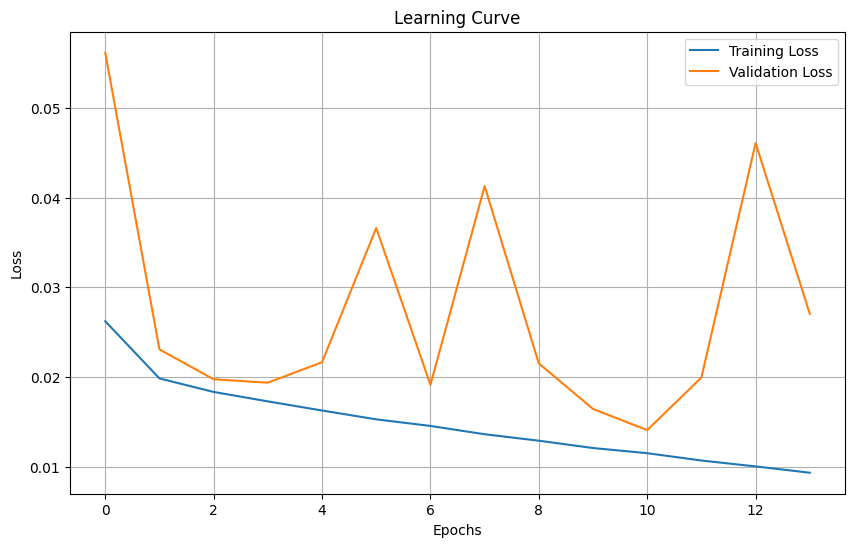

In [24]:
import matplotlib.pyplot as plt

#historial de entrenamiento
train_loss = res.history["loss"]
val_loss = res.history["val_loss"]

# gráfica
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Guardar modelo entrenado
model.save("model_EfficientNetB3_PB_6B_CONEVAL_NOrp_albers_05062025_model_b.h5")
print('Model saved - ok')

Model saved - ok


In [26]:
#Predicción
height, width, channels = (224, 224, 6)

def compute_predictions(model):
	ns = 20
	y_pred = []
	for i in np.arange(0, len(x_test), ns):
		if( i % 50000 == 0.0 ):
			print(' %d%%' % int(100.0*i/len(x_test)), end='')
		imax = np.min((i+ns, len(x_test)))
		xt = []
		for j in np.arange(i, imax):
			xr = cv2.resize(x_test[j], (width,height), interpolation=cv2.INTER_CUBIC)
			xt.append(xr)
		xt = np.array(xt)
		yp = model.predict(xt)
		for j in np.arange(0, len(yp)):
			y_pred.append(yp[j])
	print('')
	return np.array(y_pred).ravel()

In [27]:
#Chunk con el que se evaluo en resnet50v2
#evaluate model
print('Results for model:')

filename = "model_EfficientNetB3_PB_6B_CONEVAL_NOrp_albers_05062025_model_b.h5"
model = models.load_model(filename)
y_pred = model.predict(test_gen)

# Reshape y_pred to be 1-dimensional
y_pred = y_pred.ravel() # or y_pred = y_pred.reshape(-1)

filename = 'predictions_regressionEfnb3_6B_CONEVAL_05062025.csv'
df = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred})
df.to_csv(filename)


#y_pred = compute_predictions(model)
y_pred= np.array(y_pred)
mse = np.mean((y_pred - y_test)**2.0)
sigma2 = np.mean((y_test - np.mean(y_test))**2.0)
R2 = 1.0 - mse/sigma2

print('  R^2 = %0.4f' % R2)
print('  mse = %0.4f' % mse)

Results for model:


764/764 ━━━━━━━━━━━━━━━━━━━━ 182s 228ms/step
  R^2 = 0.6241
  mse = 0.0143


In [28]:
from google.colab import files
files.download('model_EfficientNetB3_PB_6B_CONEVAL_NOrp_albers_05062025_model_b.h5')
files.download("training_history_EfficientNetB3_PB_6B_CONEVAL_Norp_albers_05062025_model.csv")
files.download('predictions_regressionEfnb3_6B_CONEVAL_05062025.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Código de Pablo Vera con el que hizo predicciones

In [29]:
#function to resize and crop an image
height, width = (224, 224)
scale_dim = 1.6
def resize_img(img, height, width, scale_dim):
    wd, hg = (int(scale_dim*width), int(scale_dim*height))
    img_res = cv2.resize(img, (wd, hg), interpolation=cv2.INTER_CUBIC)
    h_off = int(0.5 * (hg - height))
    w_off = int(0.5 * (wd - width))
    img_res = img_res[h_off:h_off+height, w_off:w_off+width, :]
    return img_res

In [30]:
#compute predictions
nsel = 100
ntest = len(x_test)
y_pred = []
for i in np.arange(0,ntest,nsel):
    if( i % 2000 == 0 ):
        print(i, ' - ', ntest)
    imax = np.min((i+nsel,ntest))
    xt = []
    for j in np.arange(i,imax):
        imr = resize_img(x_test[j], height, width, scale_dim)
        xt.append(imr)
    xt = np.array(xt)
    yp = model.predict(xt, verbose=0)
    for j in np.arange(0,len(yp)):
        y_pred.append(yp[j,0])

print(np.shape(y_pred))

0  -  24429
2000  -  24429
4000  -  24429
6000  -  24429
8000  -  24429
10000  -  24429
12000  -  24429
14000  -  24429
16000  -  24429
18000  -  24429
20000  -  24429
22000  -  24429
24000  -  24429
(24429,)


In [31]:
#save predictions to a csv file
filename = 'predictions_efnb3_model_6B_NOrp_CONEVAL_05062025.csv'

df = pd.DataFrame({'ind_test':ind_test,
                   'y_test':y_test,
                   'y_pred':y_pred})

df.to_csv(filename, mode='w', index=False, header=True)

In [32]:
#compute R^2
mse = np.mean((y_pred - y_test)**2.0)
sigma2 = np.mean((y_test - np.mean(y_test))**2.0)
R2 = 1.0 - mse/sigma2

print(f'MSE = {mse:0.4f}')
print(f'R^2 = {R2:0.4f}')

MSE = 0.0143
R^2 = 0.6241


In [33]:
#compute correlation
r = np.corrcoef(y_pred, y_test)

print(r)

[[1.         0.79570139]
 [0.79570139 1.        ]]


In [34]:
from google.colab import files
files.download("predictions_efnb3_model_6B_NOrp_CONEVAL_05062025.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
from tensorflow.keras import models
import pandas as pd
import numpy as np
import cv2

height, width = 224, 224
scale_dim = 1.6

# Función auxiliar
def resize_img(img, height, width, scale_dim):
    wd, hg = (int(scale_dim*width), int(scale_dim*height))
    img_res = cv2.resize(img, (wd, hg), interpolation=cv2.INTER_CUBIC)
    h_off = int(0.5 * (hg - height))
    w_off = int(0.5 * (wd - width))
    img_res = img_res[h_off:h_off+height, w_off:w_off+width, :]
    return img_res

# Leer identificadores
df_base = pd.read_excel("/content/drive/MyDrive/Colab/Albers/Arreglos y bases/Base_Albers_Final_81k.xlsx",
                        usecols=["CVEGEO", "CVE_ENT", "CVE_MUN", "CVE_LOC", "CVE_AGEB", "Coneval_2020"])

# Predecir para todos los datos
n_total = len(x_imgs)
batch_size_pred = 100
y_pred_all = []

for i in range(0, n_total, batch_size_pred):
    print(f"Procesando {i}/{n_total}")
    i_max = min(i + batch_size_pred, n_total)
    xt = [resize_img(x_imgs[j], height, width, scale_dim) for j in range(i, i_max)]
    xt = np.array(xt)
    yp = model.predict(xt, verbose=0)
    y_pred_all.extend(yp[:, 0])

# Agregar predicciones
df_base["y_pred"] = y_pred_all

# Evaluación (opcional, si tienes P_INDEX01)
y_true = df_base["Coneval_2020"].values
mse = np.mean((y_pred_all - y_true) ** 2)
sigma2 = np.mean((y_true - np.mean(y_true)) ** 2)
R2 = 1.0 - mse / sigma2

print("Resultados en base completa:")
print(f"  R^2 = {R2:.4f}")
print(f"  MSE  = {mse:.4f}")

# Guardar predicciones con identificadores
df_base.to_csv("predicciones_completas_6B_CONEVAL_noRP_05062025_con_ids_.csv", index=False)


Procesando 0/81428
Procesando 100/81428
Procesando 200/81428
Procesando 300/81428
Procesando 400/81428
Procesando 500/81428
Procesando 600/81428
Procesando 700/81428
Procesando 800/81428
Procesando 900/81428
Procesando 1000/81428
Procesando 1100/81428
Procesando 1200/81428
Procesando 1300/81428
Procesando 1400/81428
Procesando 1500/81428
Procesando 1600/81428
Procesando 1700/81428
Procesando 1800/81428
Procesando 1900/81428
Procesando 2000/81428
Procesando 2100/81428
Procesando 2200/81428
Procesando 2300/81428
Procesando 2400/81428
Procesando 2500/81428
Procesando 2600/81428
Procesando 2700/81428
Procesando 2800/81428
Procesando 2900/81428
Procesando 3000/81428
Procesando 3100/81428
Procesando 3200/81428
Procesando 3300/81428
Procesando 3400/81428
Procesando 3500/81428
Procesando 3600/81428
Procesando 3700/81428
Procesando 3800/81428
Procesando 3900/81428
Procesando 4000/81428
Procesando 4100/81428
Procesando 4200/81428
Procesando 4300/81428
Procesando 4400/81428
Procesando 4500/81428


In [36]:
from google.colab import files
files.download("predicciones_completas_6B_CONEVAL_noRP_05062025_con_ids_.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>